In [1]:
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import time
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


### Making the Model

In [2]:
class CausalSelfAttention(nn.Module): #A.K.A Masked Self Attention.

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though Registering a buffer cause it is not a learnable parameter
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)

        #Before Transpose, the shape of k was (B, T, nh, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # # attention (materializes the large (T,T) matrix for all the queries and keys)
    
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) #It is scaled so that the variance remains one and prevents it  from becoming one hot kinda vector after softmax.
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs) Note how batched matrix multiplication works
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd) #The 4 is because of the MLP architecture used in the GPT-2 paper. Was also in the "Attention is all you need" paper
        self.gelu    = nn.GELU(approximate='tanh') #Approximate GELU is used in the GPT-2 paper cause of Tensorflow IG. The exact GELU is also fine. 
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()

        # Note the pre norm here. This is different from the "Attention is all you need" paper where they use post norm
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x)) #Residual connection
        x = x + self.mlp(self.ln_2(x)) #Residual connection
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        #Using nn.ModuleDict so that it is convienent to load the weights from huggingface and the names are also consistent with it
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd), #Not using sine and cosine positional embeddings
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        #Tying weights of the embedding layer and the final linear layer.This was also mentioned in the "Attention is all you need" paper
        self.transformer.wte.weight = self.lm_head.weight 

    def forward(self, idx):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)

        x = tok_emb + pos_emb # Note that the pos_emb will be broadcasted B times. "Shift right and apt dimension"

        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)

        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        return logits
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("Weights are loaded from pretrained GPT: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args) #** is used to unpack the dictionary so that individual arguments are passed to the function
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        #I suspect that it is somewhat relatable to what is used in VIT. In it there are two ways to embed a patch either to unpack the all the pixels across all channels or to use a Conv1D layer to embed the patches.
        #and in convD method the filters were the "features" and we had to transpose them.

        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


### Pre processing the data on which my GPT will be trained

In [3]:
batch_size=4
seq_length=512

# Loading text and pre processing it
with open("/kaggle/input/shakespeare/trainingtext.txt", "r") as file:
    text = file.read()

import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(text)
tokens = torch.tensor(tokens)

#Creating Batches

num_sequences = len(tokens) // (seq_length + 1)
x = []
y = []
for i in range(0, num_sequences * (seq_length + 1), seq_length + 1):
    seq_x = tokens[i:i+seq_length]
    seq_y = tokens[i+1:i+seq_length+1]
    if len(seq_y) == seq_length:  
        x.append(seq_x)
        y.append(seq_y)

x = torch.stack(x)
y = torch.stack(y)

# train test split
train_size = .8     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int( x.shape[0]* train_size)
train_x, remain_x = x[:split_id], x[split_id:]
train_y, remain_y = y[:split_id], y[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]


trainset = TensorDataset(train_x,train_y)
validset = TensorDataset(val_x,val_y)
testset = TensorDataset(test_x,test_y)

train_dataloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [4]:
def train_loop(train_dataloader,val_dataloader,model,loss_fn,optimizer,batch_size,epoch):
    train_start_time = time.time()

    train_size=len(train_dataloader.dataset)
    num_batches=len(train_dataloader)
    loss_tot=0
    train_correct=0

    for batch,(X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()
        pred=model(X)
        loss=loss_fn(pred.view(-1,pred.shape[-1]),y.view(-1)) #loss_fn(nn.CrossEntropyLoss) expects the input to be of shape (N,C) where C is the number of classes. So we need to reshape the input and target to (N,C) where C is the number of classes.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot+=loss.item()
        
        model.eval()
        pred=model(X)
        train_correct_each = (pred.argmax(2) == y).type(torch.float).sum().item()
        train_acc=train_correct_each/(y.shape[0]*seq_length)
        train_correct+=train_correct_each
        loss, current = loss.item(), batch * batch_size + len(X)

        train_end_time = time.time() 
        train_duration = train_end_time - train_start_time 

        print(f"\rEpoch {epoch+1} : Training loss: {loss:>7f} - Training Accuracy: {train_acc:>7f}  [{current:>5d}/{train_size:>5d}] - Training Time: {train_duration:.2f}s", end="")

    loss_avg=loss_tot/num_batches
    train_acc = train_correct/(train_size*seq_length)

    val_loss = 0
    val_correct=0
    val_size=len(val_dataloader.dataset)

    model.eval()
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred.view(-1,pred.shape[-1]),y.view(-1)).item()
            val_correct += (pred.argmax(2) == y).type(torch.float).sum().item()
    val_loss /= len(val_dataloader)
    val_acc=val_correct/(val_size*seq_length)

    print(f"\rEpoch {epoch+1} : Training loss: {loss_avg:>7f} - Training Accuracy: {train_acc:>7f} - Validation loss: {val_loss:>7f} - Validation accuracy: {val_acc:>7f} - Training Time: {train_duration:.2f}s")
    print(end='')
    return loss_avg, train_acc, val_loss, val_acc


def test_loop(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    model.eval()
    num_batches=len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred.view(-1,pred.shape[-1]),y.view(-1)).item()
            correct += (pred.argmax(2) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc=correct/size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

config = GPTConfig()
model=GPT(GPTConfig()).to(device)
learning_rate = 1e-3
batch_size = batch_size
epochs = 60
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

sample_input_for_summary = torch.randint(0, config.vocab_size, (batch_size, config.block_size)).to(device)

summary(model, input_data=sample_input_for_summary)

Layer (type:depth-idx)                             Output Shape              Param #
GPT                                                [4, 1024, 50257]          --
├─ModuleDict: 1-1                                  --                        --
│    └─Embedding: 2-1                              [1024, 768]               786,432
│    └─Embedding: 2-2                              [4, 1024, 768]            38,597,376
│    └─ModuleList: 2-3                             --                        --
│    │    └─Block: 3-1                             [4, 1024, 768]            7,087,872
│    │    └─Block: 3-2                             [4, 1024, 768]            7,087,872
│    │    └─Block: 3-3                             [4, 1024, 768]            7,087,872
│    │    └─Block: 3-4                             [4, 1024, 768]            7,087,872
│    │    └─Block: 3-5                             [4, 1024, 768]            7,087,872
│    │    └─Block: 3-6                             [4, 1024, 768]  

In [5]:
loss_history = {'train': [], 'val': []}
accuracy_history = {'train': [], 'val': []}

best_val_loss = float('inf')
patience = 3  # How many epochs to wait after last improvement
patience_counter = 0 
min_delta=0.001

for t in range(epochs):
    print(f"Epoch {t+1}",end=" ")
    train_loss, train_accuracy, val_loss, val_accuracy =train_loop(train_dataloader,validation_dataloader, model, loss_fn, optimizer,batch_size,t)
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    accuracy_history['train'].append(train_accuracy)
    accuracy_history['val'].append(val_accuracy)

    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        patience_counter += 1 
    
    # if patience_counter >= patience:
    #     print(f"\nStopping early at epoch {t+1} with restoring best weights")
    #     epochs=t+1
    #     break 

# test_loop(test_dataloader, model, loss_fn)

Epoch 1 : Training loss: 6.722118 - Training Accuracy: 0.112854 - Validation loss: 6.653086 - Validation accuracy: 0.117335 - Training Time: 50.36s
Epoch 2 : Training loss: 6.412958 - Training Accuracy: 0.117670 - Validation loss: 6.632313 - Validation accuracy: 0.117335 - Training Time: 50.23s
Epoch 3 : Training loss: 6.385350 - Training Accuracy: 0.117670 - Validation loss: 6.629883 - Validation accuracy: 0.117335 - Training Time: 50.25s
Epoch 4 : Training loss: 6.371334 - Training Accuracy: 0.117670 - Validation loss: 6.622586 - Validation accuracy: 0.117335 - Training Time: 50.29s
Epoch 5 : Training loss: 6.361183 - Training Accuracy: 0.117670 - Validation loss: 6.635438 - Validation accuracy: 0.117335 - Training Time: 50.29s
Epoch 6 : Training loss: 6.349717 - Training Accuracy: 0.117670 - Validation loss: 6.618912 - Validation accuracy: 0.117335 - Training Time: 50.31s
Epoch 7 : Training loss: 6.328615 - Training Accuracy: 0.117670 - Validation loss: 6.640287 - Validation accurac

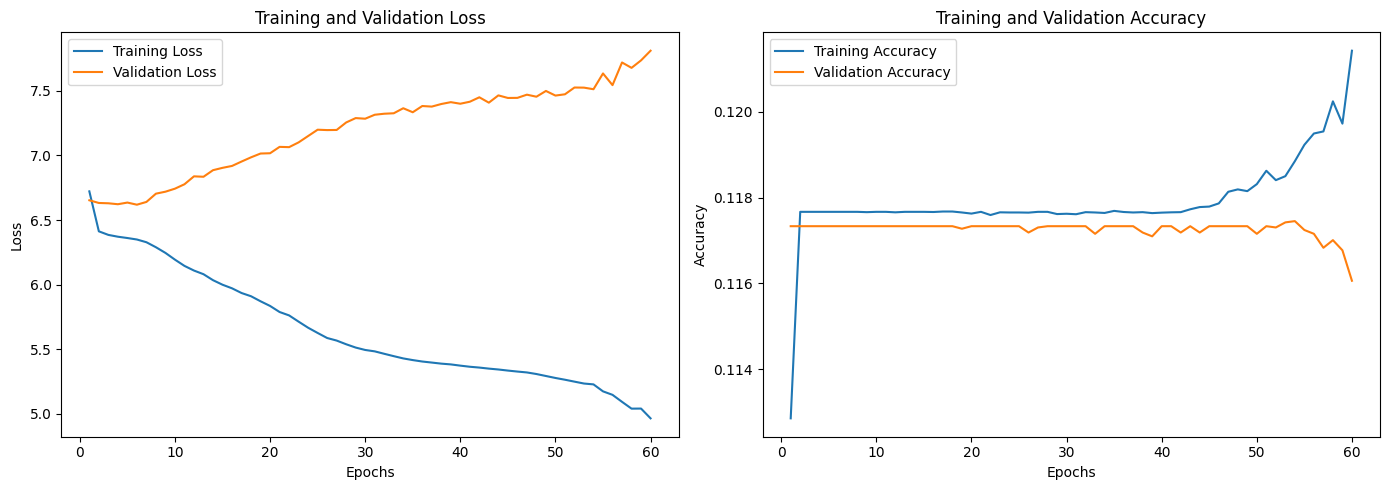

In [6]:
plt.figure(figsize=(14, 5))
eplist=[]
for i in range(epochs):
    eplist.append(i+1)
plt.subplot(1, 2, 1)
plt.plot(eplist, loss_history['train'], label='Training Loss')
plt.plot(eplist, loss_history['val'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eplist, accuracy_history['train'], label='Training Accuracy')
plt.plot(eplist, accuracy_history['val'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Generating text by the GPT I trained on training.txt

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_return_sequences = 1
max_length = 30

import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("First") #Tiktoken gives list of tokens
tokens = torch.tensor(tokens, dtype=torch.long) 
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) 
x = tokens.to(device)

while x.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # Note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1) #(B,some number s.t greater than initial number of tokens and less than ≈max_length )


for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist() #Tiktoken supports only list so converting it to list
    decoded = enc.decode(tokens)
    print(">", decoded)

> First not but they
,
: we thereby like thee falls.Supp a you have upon'sO,.
, I of
..


### Using Hugging face weights and generating

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT.from_pretrained('gpt2').to(device)
num_return_sequences = 5
max_length = 30

import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,") #Tiktoken gives list of tokens
tokens = torch.tensor(tokens, dtype=torch.long) # (8,) There are 8 tokens in the sentence. Tiktokeniser visualiser the versel one is a nice website :P
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
x = tokens.to(device)

while x.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # Note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1) #(B,some number s.t greater than initial number of tokens and less than ≈max_length )


for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist() #Tiktoken supports only list so converting it to list
    decoded = enc.decode(tokens)
    print(">", decoded)

Weights are loaded from pretrained GPT: gpt2


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

> Hello, I'm a language model, it's like a human body. We're like a monkey with its human mind, it's like a chimpan
> Hello, I'm a language model, I want to be comfortable with it, it's simple, it's really open source," says Ryan Gee
> Hello, I'm a language model, if you're not into that one yet, please get in touch.

The last chapter, Chapter 13
> Hello, I'm a language model, an idea model. I'm interested in how language theory shapes the world and how language itself can influence its creation
> Hello, I'm a language model, a programming language. I'm interested in thinking about programming languages and how they shape our lives. I was inspired
